# Определение стоимости автомобилей

Даны исторические данные сервиса по продаже автомобилей с пробегом.\
Необходимо построить модель машинного обучения, для определения стоимости.


Признаки:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак:

* Price — цена (евро)


## Подключение библиотек и чтение файла с данными

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/datasets/autos.csv')

## Подготовка данных

In [2]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Преобразовали имена признаков в snake_case

In [4]:
def date_decomposition(df): # раскладывает дату создания анкеты на месяца и года
    df['date_created']= df['date_created'].astype('datetime64[ns, US/Eastern]')
    df['year_created'] = pd.DatetimeIndex(df['date_created']).year
    df['month_created'] = pd.DatetimeIndex(df['date_created']).month
    return df

Года помогут высчитать возраст автомобиля, а месяцы отследить сезонность если такая есть. (Видимо сезонность плохой показатель, модель с месяцами предсказывает хуже.)

In [5]:
def deleting_columns(df, columns_list): # удаляем лишние признаки
    df = df.drop(columns_list, axis=1)
    return df

delet_columns = ['date_crawled', 'registration_year', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen',
                 'year_created', 'registration_month', 'month_created'] # кандидаты на удаление

In [6]:
df.isnull().sum().sort_values(ascending=False) / df.shape[0]

not_repaired          0.200791
vehicle_type          0.105794
fuel_type             0.092827
gearbox               0.055967
model                 0.055606
last_seen             0.000000
postal_code           0.000000
number_of_pictures    0.000000
date_created          0.000000
brand                 0.000000
registration_month    0.000000
kilometer             0.000000
power                 0.000000
registration_year     0.000000
price                 0.000000
date_crawled          0.000000
dtype: float64

В столбце с not_repaired 20% пропусков, возможно эти автомобили не ремонтировались и поэтому эта графа не заполнялась. Буду тестировать на моделях, а пока промаркирую

Тип кузова, тип топлева, тип коробки передач и модель автомобиля промаркеруем

In [7]:
def marking(df, columns_list): # функция для маркировки
    [df[i].fillna('unknown', inplace=True) for i in columns_list]
    return df

mark_list = ['vehicle_type','fuel_type','gearbox','model', 'not_repaired'] # кандидаты на маркировку

In [8]:
def not_repaired_clean(df):# меняет пропуски на 'no'(прогноз ухудшился)
    df['not_repaired'].fillna('no')
    return df

In [9]:
df.describe(include='all')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


In [10]:
def graphic_maker(column, name, ylim):
    plt.figure(figsize=(13,10), dpi= 80)
    sns.distplot(df[column], color="g", label= name, hist_kws={'alpha':.7})

    plt.figure(figsize=(8,10), dpi= 80)
    sns.boxplot(y=column, data=df)
    plt.title(name, fontsize=22)
    plt.ylim(ylim)
    
    plt.show()

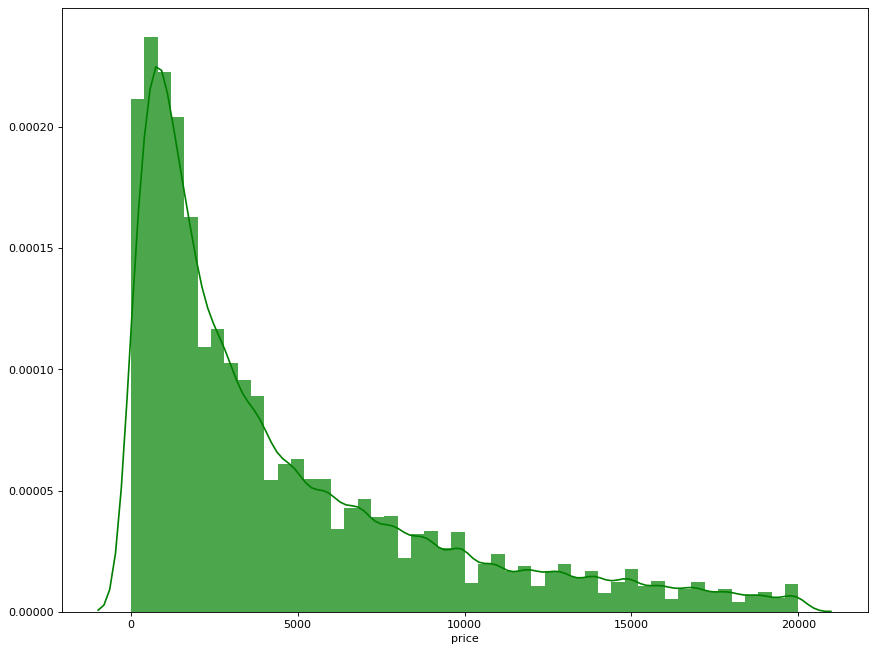

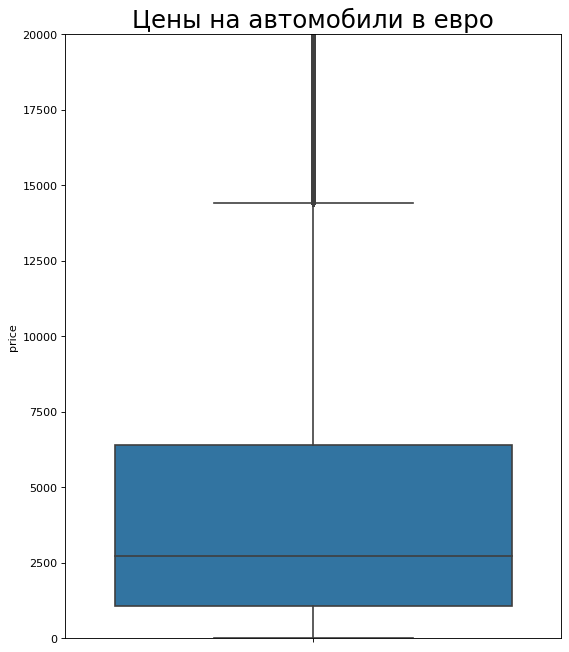

In [11]:
graphic_maker('price', 'Цены на автомобили в евро', [0, 20000])

In [12]:
df.groupby(['price'])['price'].count().head(50)

price
0     10772
1      1189
2        12
3         8
4         1
5        26
7         3
8         9
9         8
10       84
11        5
12        8
13        7
14        5
15       27
16        2
17        5
18        3
19        3
20       51
21        1
24        1
25       33
26        1
27        1
29        2
30       55
32        1
33        1
35       18
38        1
39        6
40       45
45       16
47        1
49       12
50      327
55       20
58        1
59        6
60       58
65       19
66        2
69        3
70       69
74        1
75       54
77        1
79        4
80      146
Name: price, dtype: int64

In [13]:
df.loc[df['price'] == 0] 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


По целевому признаку странное распределение, но учитывая всплески на круглых цифрах предположу что это действительно заполняли люди, и возможно они хотят просто избавиться от своего старого либо битого автомобиля

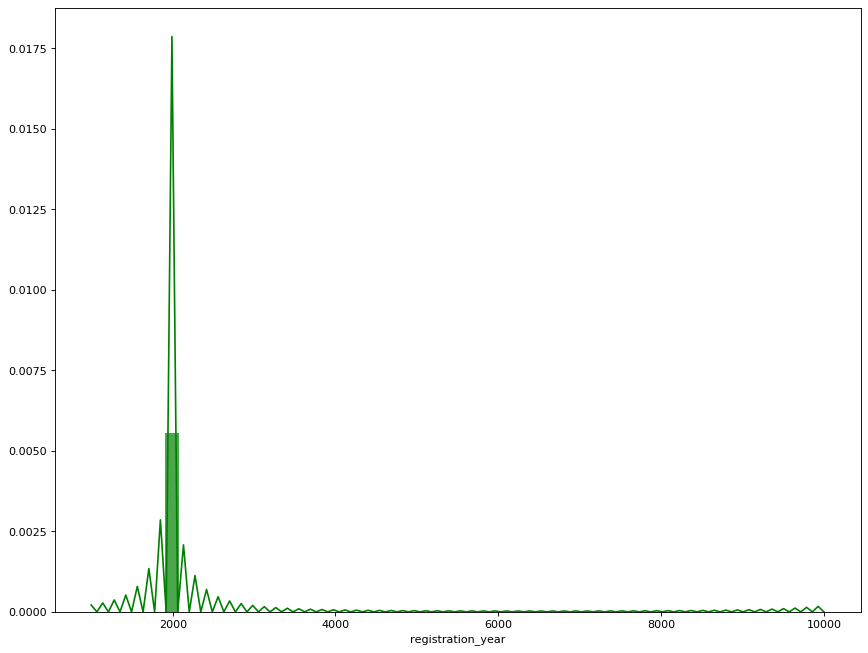

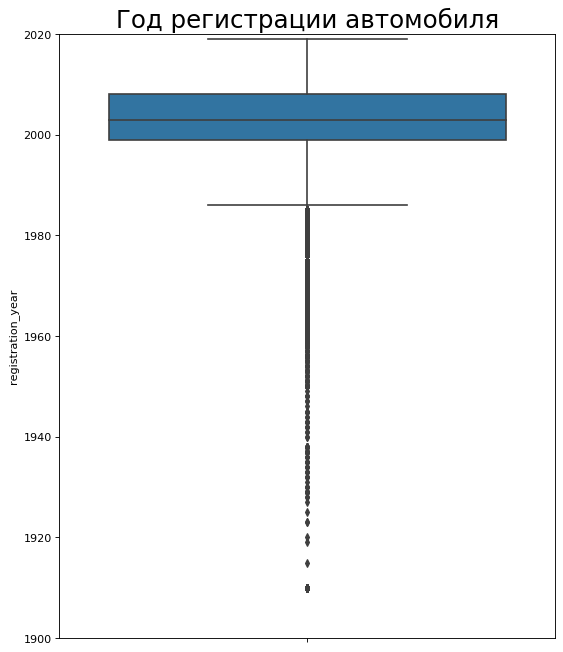

In [14]:
graphic_maker('registration_year', 'Год регистрации автомобиля', [1900, 2020])

В годе регистрации множество явных ошибок(автомобили марки которых зарегистрированы позже чем сами автомобили). Пожертвуем одним процентом данных, даже если среди них попадутся действительно антикварные авто, они будут плохо обобщаться и негативно скажутся на качестве нашей модели. Также есть автомобили из будущего.)))

In [15]:
lower_limit_year = df['registration_year'].quantile(0.01) # удалим один процент самых старых авто
lower_limit_year

1980.0

In [16]:
df.loc[df['registration_year'] < lower_limit_year].sort_values('registration_year',ascending=False).head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
317352,2016-03-22 12:45:49,3500,bus,1979,manual,50,transporter,125000,3,petrol,volkswagen,no,2016-03-22 00:00:00,0,19063,2016-04-06 01:16:10
29135,2016-03-11 21:40:50,12900,convertible,1979,manual,126,spider,20000,4,petrol,alfa_romeo,no,2016-03-11 00:00:00,0,47475,2016-04-06 05:46:30
255455,2016-03-25 19:46:49,9300,coupe,1979,manual,63,NaN,125000,5,petrol,opel,no,2016-03-25 00:00:00,0,66440,2016-04-07 02:15:20
150919,2016-03-23 19:41:07,17900,convertible,1979,manual,50,kaefer,150000,12,petrol,volkswagen,no,2016-03-23 00:00:00,0,81479,2016-04-02 02:16:26
150927,2016-03-25 19:52:43,2000,sedan,1979,manual,107,other,150000,0,petrol,volvo,no,2016-03-25 00:00:00,0,29456,2016-04-07 02:45:59
151941,2016-04-01 14:47:14,1800,small,1979,manual,45,other,150000,11,petrol,mini,no,2016-04-01 00:00:00,0,85417,2016-04-07 11:45:57
255485,2016-03-12 21:47:33,750,coupe,1979,manual,0,other,150000,0,NaN,opel,NaN,2016-03-12 00:00:00,0,96476,2016-03-15 09:17:17
104316,2016-03-07 09:06:36,0,wagon,1979,NaN,0,NaN,100000,4,gasoline,sonstige_autos,NaN,2016-03-07 00:00:00,0,57234,2016-03-08 17:32:56
55856,2016-03-08 17:39:35,0,sedan,1979,NaN,0,NaN,100000,0,NaN,opel,NaN,2016-03-08 00:00:00,0,21224,2016-03-09 16:48:00
152935,2016-03-17 07:36:25,800,sedan,1979,manual,46,other,70000,2,petrol,skoda,no,2016-03-17 00:00:00,0,16827,2016-03-20 09:50:04


In [17]:
def cleaning_registration_year(df): # почистим год регистрации
    before = df.shape[0]
    df = df.loc[df['registration_year'] < df['year_created']]
    df = df.loc[df['registration_year'] > lower_limit_year]
    after = df.shape[0]
    print('Доля автомобилей которые продаются раньше чем были зарегистрированы{:.2%}'.format((before - after) / before))
    return df            

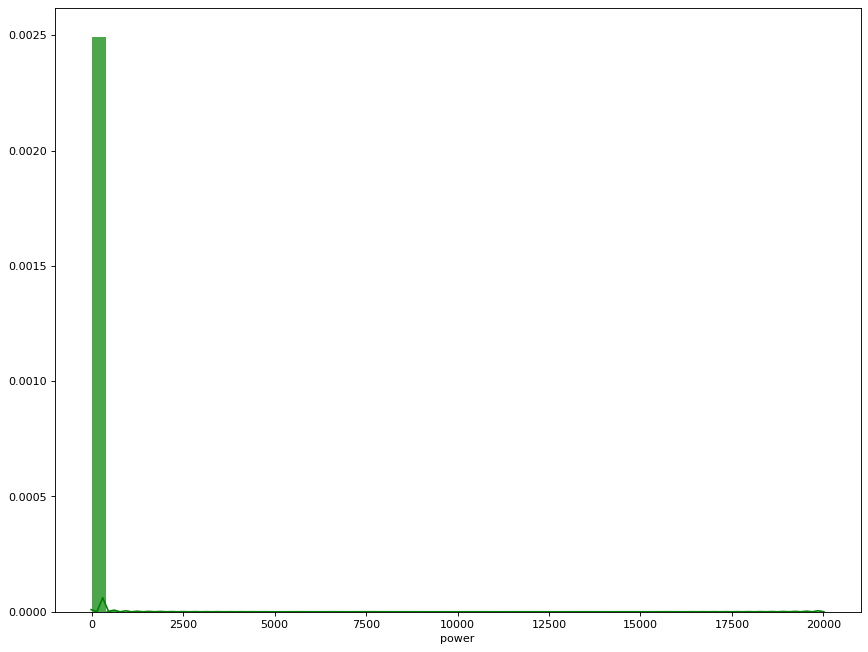

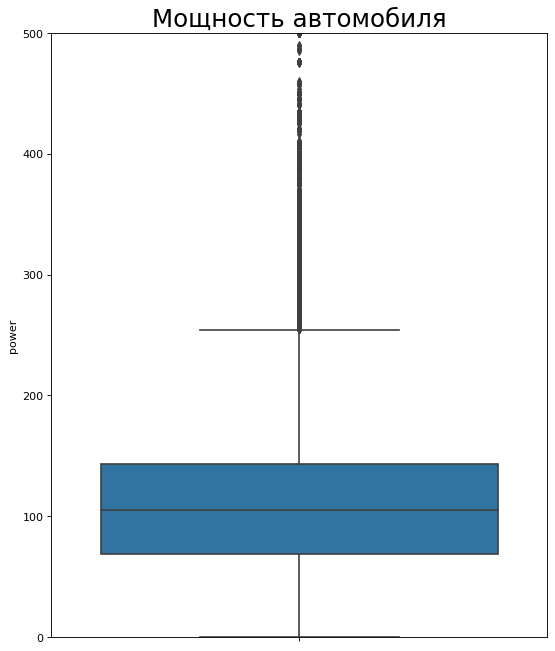

In [18]:
graphic_maker('power', 'Мощность автомобиля', [0, 500])

In [19]:
df.groupby(['power'])['power'].count().head(10)

power
0    40225
1       34
2       10
3        9
4       30
5      103
6       11
7       11
8        7
9        5
Name: power, dtype: int64

In [20]:
df.groupby(['power'])['power'].count().tail(10)

power
16312    1
17011    1
17019    1
17410    1
17700    1
17932    1
19208    1
19211    1
19312    1
20000    1
Name: power, dtype: int64

In [21]:
lower_limit_power = df['power'].quantile(0.12)
lower_limit_power

43.0

In [22]:
upper_limit_power = df['power'].quantile(0.99)
upper_limit_power

300.0

In [23]:
def cleaning_power(df): # пробуем заменить медианным значением сгруппировав по признакам влияющим на мощность
    df.loc[(df['power'] < lower_limit_power) | (df['power'] > upper_limit_power), 'power'] \
    = df.loc[(df['power'] > lower_limit_power) & (df['power'] < upper_limit_power)]\
    .groupby(['brand', 'model', 'fuel_type'])['power'].transform('mean')
    return df

Возможно владельцы автомобилей просто не знают мощность своего транспортного средства, и по этой причине заполняли наугад. Попробуем промаркировать 12% нижних значений и 0.1% верхних.

Пробовал заменять предполагаемые выбросные значения, на медиану,среднее группируя по другим признакам, пробовал маркировать 0. Модель показывает наивысшую точность если не трогать данные. Возможно это связано с тем что много автомобилей не на ходу.

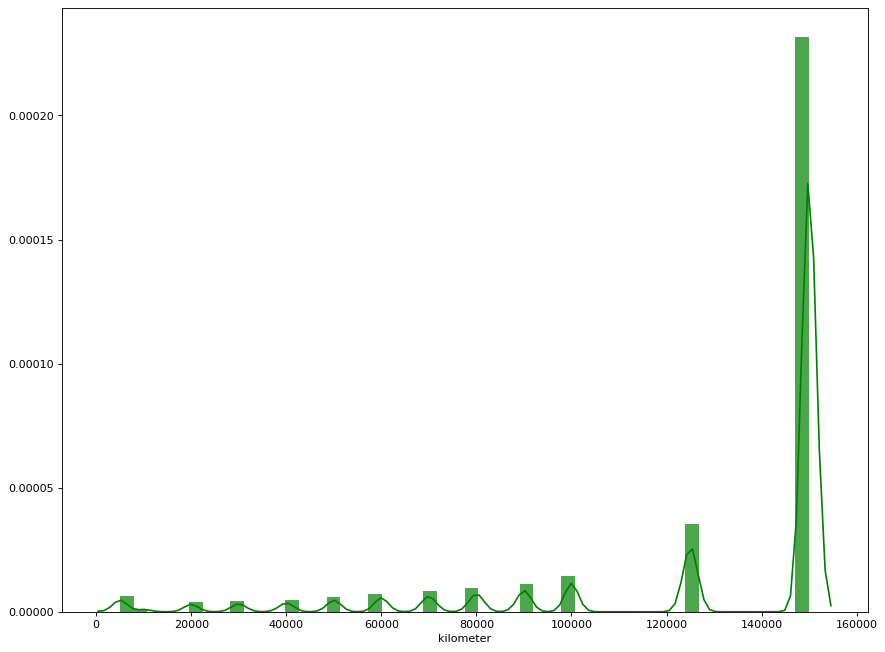

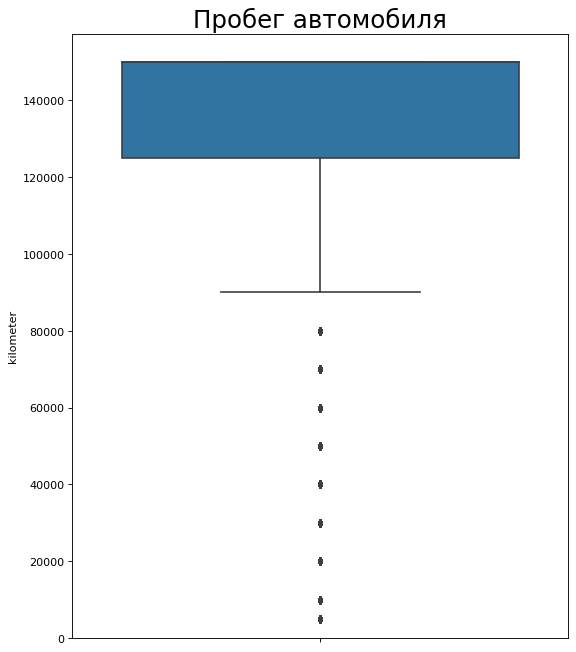

In [24]:
graphic_maker('kilometer', 'Пробег автомобиля', 0)

50% всех значений находится на черте в 150 000 км. Видимо здесь есть ограничение. Пока нет идей как можно повысить информативность этого признака.

In [25]:
def checking_unique (series):
    print(series.unique(), '\n')

Проверим на корректность записи категориальные признаки

In [26]:
print('Тип кузова:')
checking_unique (df['vehicle_type'])
print('Модель автомобиля:')
checking_unique (df['model'])
print('Марка автомобиля')
checking_unique (df['brand'])

Тип кузова:
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

Модель автомобиля:
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' '

Очевидных различий записи не вижу

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
date_crawled          354369 non-null object
price                 354369 non-null int64
vehicle_type          316879 non-null object
registration_year     354369 non-null int64
gearbox               334536 non-null object
power                 354369 non-null int64
model                 334664 non-null object
kilometer             354369 non-null int64
registration_month    354369 non-null int64
fuel_type             321474 non-null object
brand                 354369 non-null object
not_repaired          283215 non-null object
date_created          354369 non-null object
number_of_pictures    354369 non-null int64
postal_code           354369 non-null int64
last_seen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [28]:
def changing_tupe(df,categorial_columns): # поменяем тип данных
    df[categorial_columns] = df[categorial_columns].astype('category')
    return df

categorial_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
numeric_columns = ['power', 'kilometer', 'cars_age']

Предполагаю что возраст автомобиля будет лучше обобщаться и работать в будущем, чем год регистрации авто

In [29]:
def creating_fitchers(df): # создает признаки
    df['cars_age'] = df['year_created'] - df['registration_year']
    return df

In [30]:
def preprocessing(df):
    df = date_decomposition(df) # раскладывает дату создания анкеты, на месяца и года
    df = cleaning_registration_year(df) # почистим год регистрации
    df = marking(df, mark_list) # функция для маркировки
    #df = cleaning_power(df) # маркирует "повозки" и "суперкары"(отказался от этой функции) 
    #df = not_repaired_clean(df) меняет пропуски на 'no' (гипотеза не подтвердилась)
    df = changing_tupe(df,categorial_columns) # поменяем тип данных
    df = creating_fitchers(df) # создает признаки
    df = deleting_columns(df, delet_columns) # удаляем лишние признаки
    return df

Разделим данные на обучающую и тестовую выборки

In [31]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

Отделим целевой признак и подготовим признаки

In [32]:
train_df = preprocessing(train_df) 
test_df = preprocessing(test_df) 

Доля автомобилей которые продаются раньше чем были зарегистрированы7.95%
Доля автомобилей которые продаются раньше чем были зарегистрированы7.96%


In [33]:
def target_spliter(df): # отделяет целевой признак
    x = deleting_columns(df, 'price')
    y = df['price']
    return x, y

In [34]:
features_train, target_train = target_spliter(train_df)
features_test, target_test = target_spliter(test_df)

In [35]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244658 entries, 236946 to 121958
Data columns (total 9 columns):
vehicle_type    244658 non-null category
gearbox         244658 non-null category
power           244658 non-null int64
model           244658 non-null category
kilometer       244658 non-null int64
fuel_type       244658 non-null category
brand           244658 non-null category
not_repaired    244658 non-null category
cars_age        244658 non-null int64
dtypes: category(6), int64(3)
memory usage: 9.1 MB


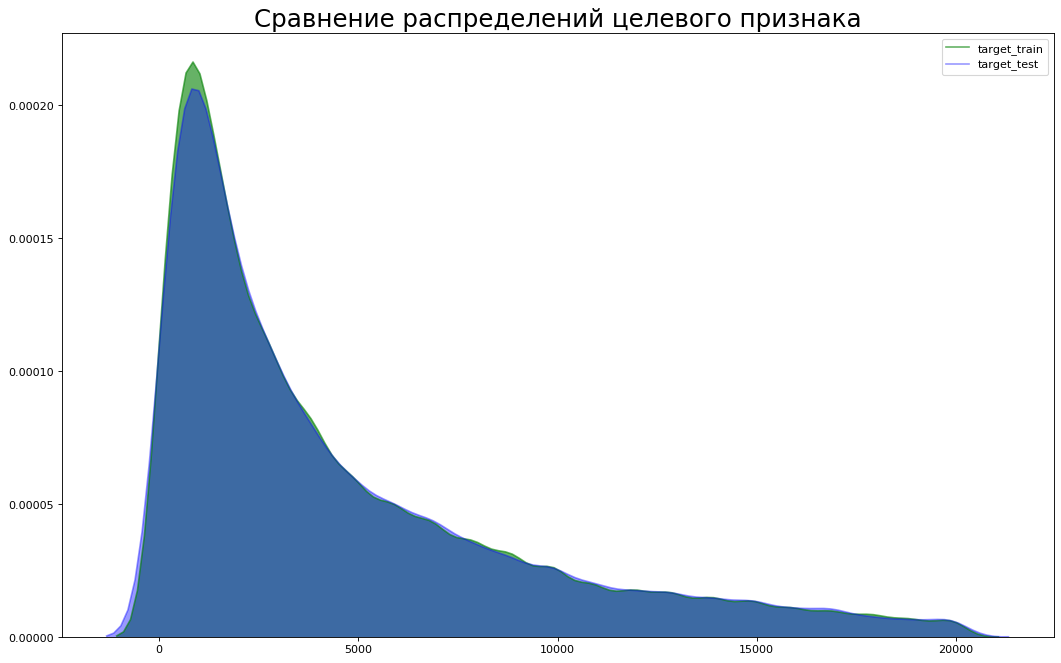

In [36]:
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(target_train, shade=True, color="g", label="target_train", alpha=.6)
sns.kdeplot(target_test, shade=True, color="b", label="target_test", alpha=.4)

plt.title('Сравнение распределений целевого признака', fontsize=22)
plt.legend()
plt.show()






Выборки разделились хорошо

### Обучение моделей

In [37]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

In [38]:
models_scors = pd.DataFrame(columns = ['model', 'rmse', 'lirning_time', 'predicting_time'])

In [39]:
%%time
best_scor = 1e12
best_depth = 0
best_iteration = 0
for rate in [0.28]:
    for depth in [2]:
        lgbm_model = LGBMRegressor(learning_rate=rate, depth=depth, random_seed=42,
                        loss_function='RMSE',
                        cat_features=categorial_columns)
        start_time = time.time()
        lgbm_model.fit(features_train, target_train)
        lirning_time = time.time() - start_time
        start_time = time.time()
        prediction = lgbm_model.predict(features_test)
        predicting_time = time.time() - start_time
        scor = mean_squared_error(target_test, prediction)
        if scor < best_scor:
            best_scor = scor
            best_depth = depth
            best_rate = rate
print(f' rmse: {best_scor ** 0.5}, глубина: {best_depth}, размер шага: {best_rate}')

models_scors = models_scors.append({'model': 'LGBMRegressor', 'rmse': best_scor ** 0.5,
                    'lirning_time': lirning_time, 'predicting_time': predicting_time}, ignore_index=True)

 rmse: 1630.8567361575083, глубина: 2, размер шага: 0.28
CPU times: user 6.66 s, sys: 0 ns, total: 6.66 s
Wall time: 6.67 s


Подберем важные признаки, остальные удалим на предыдущих этапах

In [40]:

features_train_importance = pd.DataFrame({'name' : features_train.columns,
                                          'importance' : lgbm_model.feature_importances_})
features_train_importance = features_train_importance.sort_values('importance', ascending=False)
features_train_importance

,name,importance
2,power,704
8,cars_age,661
3,model,636
4,kilometer,331
6,brand,232
0,vehicle_type,159
1,gearbox,110
7,not_repaired,106
5,fuel_type,61


In [41]:
%%time
best_scor = 1e12
best_depth = 0
best_iteration = 0
for rate in [0.1]:
    for depth in [11]:
        cbr_model = CatBoostRegressor(learning_rate=rate, depth=depth, random_seed=42, silent=True,
                        loss_function='RMSE',
                        cat_features=categorial_columns)
        start_time = time.time()                
        cbr_model.fit(features_train, target_train)
        lirning_time = time.time() - start_time
        start_time = time.time()
        prediction = cbr_model.predict(features_test)
        predicting_time = time.time() - start_time
        scor = mean_squared_error(target_test, prediction)
        scor = abs(scor.mean())
        if scor < best_scor:
            best_scor = scor
            best_depth = depth
            best_rate = rate
print(f' rmse: {best_scor ** 0.5}, глубина: {best_depth}, размер шага: {best_rate}')

models_scors = models_scors.append({'model': 'CatBoostRegressor', 'rmse': best_scor ** 0.5,
                    'lirning_time': lirning_time, 'predicting_time': predicting_time}, ignore_index=True)

 rmse: 1583.5760021554102, глубина: 11, размер шага: 0.1
CPU times: user 34min 37s, sys: 1min 48s, total: 36min 26s
Wall time: 36min 29s


In [42]:
dummy_model = DummyRegressor(strategy='median')

start_time = time.time()
dummy_model.fit(features_train, target_train)
lirning_time = time.time() - start_time
start_time = time.time()
prediction = dummy_model.predict(features_test)
predict_time = time.time() - start_time
scor = mean_squared_error(target_test, prediction)
print(f' rmse: {scor ** 0.5}')

models_scors = models_scors.append({'model': 'DummyRegressor', 'rmse': scor ** 0.5,
                    'lirning_time': lirning_time, 'predicting_time': predicting_time}, ignore_index=True)


 rmse: 4887.104789529105


## Анализ моделей

In [43]:
models_scors

,model,rmse,lirning_time,predicting_time
0,LGBMRegressor,1630.856736,6.441303,0.809197
1,CatBoostRegressor,1583.576002,2185.650834,3.649211
2,DummyRegressor,4887.104790,0.006060,3.649211


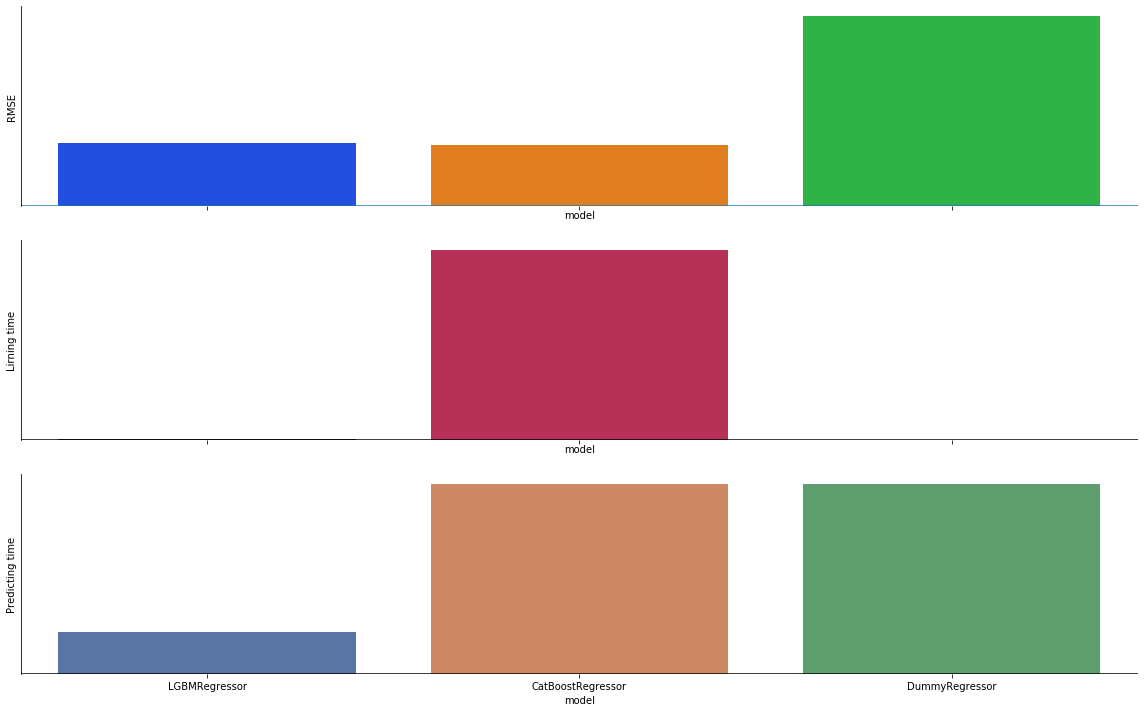

In [44]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

x = models_scors['model']
y1 = models_scors['rmse']
sns.barplot(x=x, y=y1, palette="bright", ax=ax1)
ax1.axhline(0,)
ax1.set_ylabel("RMSE")


y2 = models_scors['lirning_time']
sns.barplot(x=x, y=y2, palette="rocket", ax=ax2)
ax2.axhline(0, color="k")
ax2.set_ylabel("Lirning time")


y3 = models_scors['predicting_time']
sns.barplot(x=x, y=y3, palette="deep", ax=ax3)
ax3.axhline(0, color="k")
ax3.set_ylabel("Predicting time")


sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

## Вывод

LGBMRegressor немного уступает CatBoostRegressor в точности предсказания, но зато значительно выигрывает во времени обучения и предсказания. В целом точность моделей превосходит точность глупой модели, но погрешность более чем в 1600 евро остается весьма ощутимой. 
Возможно качество предсказаний можно улучшить оптимизировав методы сбора данных, к примеру:
* ограничить года выпуска автомобилей(люди часто выбирают либо не реалистично древние года, либо будущее. А этот признак для нас является очень важным)
* убрать верхний порог в 150 000 км у пробега
+ хотелось бы понять природу признака мощность, возможно его сбор или интерпретацию можно улучшить